In [113]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [114]:
import os
os.chdir('C:/Users/eunai/Documents/컴퓨터공부/dacon/open')

In [115]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
submission=pd.read_csv('sample_submission.csv')

## NaN==No job?

In [168]:
data=pd.concat([train, test], axis=0)
data=data.reset_index().set_index("index")
data.tail()

,level_0,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
index,,,,,,,,,,,,,,,,,,,,
36452,9995,F,Y,Y,0,202500.0,Working,Incomplete higher,Married,House / apartment,-18593,-5434,1,1,1,0,Accountants,2.0,-19.0,NaN
36453,9996,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-10886,-1315,1,1,0,0,Laborers,2.0,-34.0,NaN
36454,9997,F,N,Y,0,292500.0,Working,Secondary / secondary special,Married,House / apartment,-21016,-14018,1,0,0,0,Medicine staff,2.0,-55.0,NaN
36455,9998,F,Y,N,0,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-16541,-1085,1,0,1,0,NaN,2.0,-33.0,NaN
36456,9999,F,N,Y,0,270000.0,Working,Higher education,Married,House / apartment,-9154,-187,1,0,0,1,Laborers,2.0,-11.0,NaN


In [169]:
data1=data.loc[data["DAYS_EMPLOYED"]>=0]
data1.shape

(6135, 20)

In [170]:
data1.DAYS_EMPLOYED.unique()

array([365243], dtype=int64)

DAYS_EMPLOYED가 양수인 애들은 모두 365243. 만약 이 수치가 양수이면 그만큼 무직이었다는 게 아니라 그냥 무직이라는 의미로 받아들여야 할듯.

In [171]:
data1.loc[data1["occyp_type"].isnull()==True].shape

(6135, 20)

DAYS_EMPLOYED가 양수이면 occyp_type은 결측치. 

In [172]:
data2=data.loc[data["occyp_type"].isnull()==True]
data2.shape

(11323, 20)

In [173]:
data2.loc[data2["DAYS_EMPLOYED"]>=0].shape

(6135, 20)

In [174]:
data2.loc[data2["DAYS_EMPLOYED"]<0].shape

(5188, 20)

1) occyp_type는 결측치이지만 DAYS_EMPLOYED는 음수인 사람: 5188명

2) occyp_type가 결측치이고 DAYS_EMPLOYED도 양수인 사람: 6135명

2번 유형은 무직으로 보는 게 좋을 듯

1번 유형은 어떻게 처리해야 하지...만약 2번 유형을 No job이라고 한다면 1번 유형은 unknown job이라고 바꿀까

## 1번 유형 처리

In [175]:
data.tail()

,level_0,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
index,,,,,,,,,,,,,,,,,,,,
36452,9995,F,Y,Y,0,202500.0,Working,Incomplete higher,Married,House / apartment,-18593,-5434,1,1,1,0,Accountants,2.0,-19.0,NaN
36453,9996,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-10886,-1315,1,1,0,0,Laborers,2.0,-34.0,NaN
36454,9997,F,N,Y,0,292500.0,Working,Secondary / secondary special,Married,House / apartment,-21016,-14018,1,0,0,0,Medicine staff,2.0,-55.0,NaN
36455,9998,F,Y,N,0,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-16541,-1085,1,0,1,0,NaN,2.0,-33.0,NaN
36456,9999,F,N,Y,0,270000.0,Working,Higher education,Married,House / apartment,-9154,-187,1,0,0,1,Laborers,2.0,-11.0,NaN


In [176]:
data2_type1=data2.loc[data2["DAYS_EMPLOYED"]<0]
ind=data2_type1.index

In [177]:
tmp=data["occyp_type"]
tmp[ind]="Unknown job"
data.head()

,level_0,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
index,,,,,,,,,,,,,,,,,,,,
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,Unknown job,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [178]:
data2_1=data.loc[data["occyp_type"]=="Unknown job"]
data2_1.loc[data2_1["DAYS_EMPLOYED"]>=0].shape

(0, 20)

In [179]:
data.isnull().sum()

level_0              0
gender               0
car                  0
reality              0
child_num            0
income_total         0
income_type          0
edu_type             0
family_type          0
house_type           0
DAYS_BIRTH           0
DAYS_EMPLOYED        0
FLAG_MOBIL           0
work_phone           0
phone                0
email                0
occyp_type        6135
family_size          0
begin_month          0
credit           10000
dtype: int64

## 2번 유형 처리

DAYS_EMPLOYED가 양수인 애들은 모두 똑같은 수치를 갖고 있음. 365243.

In [180]:
365243//365

1000

무직인지 1000년이 지났을 리가 없고, 모든 사람들이 똑같은 기간동안 무직이었을리도 없음. 즉, 양수값은 무직인 기간이 아니라 그냥 무직이라는 의미.

In [181]:
data2_type2=data2.loc[data2["DAYS_EMPLOYED"]>=0]
ind=data2_type2.index

In [182]:
tmp=data["occyp_type"]
tmp[ind]="No job"

In [183]:
data2_2=data.loc[data["occyp_type"]=="No job"]
data2_2.loc[data2_2["DAYS_EMPLOYED"]<0].shape

(0, 20)

In [184]:
data.isnull().sum()

level_0              0
gender               0
car                  0
reality              0
child_num            0
income_total         0
income_type          0
edu_type             0
family_type          0
house_type           0
DAYS_BIRTH           0
DAYS_EMPLOYED        0
FLAG_MOBIL           0
work_phone           0
phone                0
email                0
occyp_type           0
family_size          0
begin_month          0
credit           10000
dtype: int64

## occyp_type-credit 분포

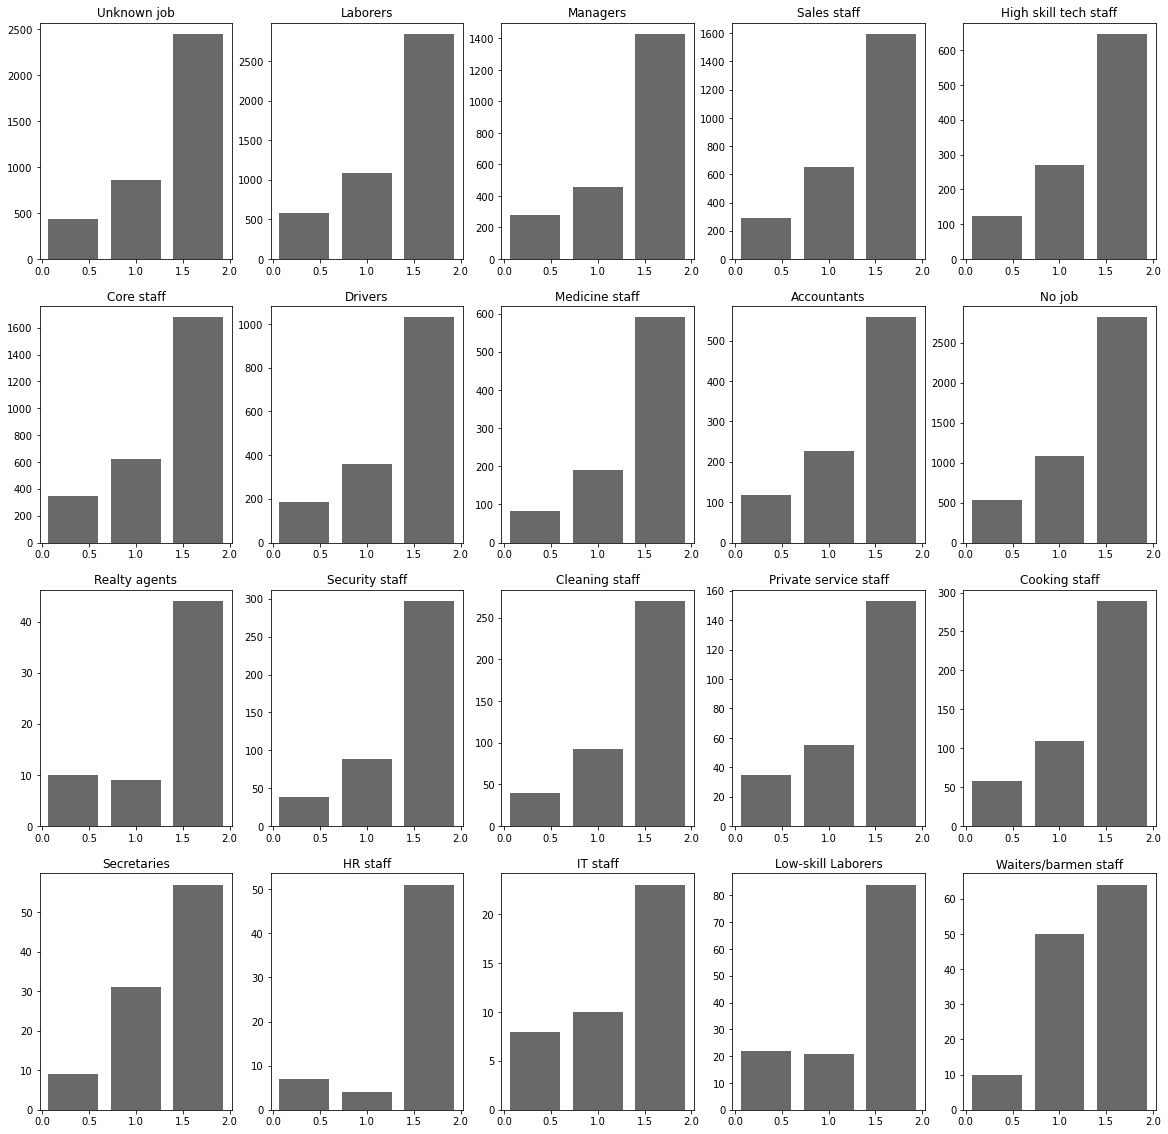

In [185]:
fig, axes = plt.subplots(4, 5, figsize=(20, 20))
j=-1
for i, w in enumerate(data["occyp_type"].unique()):
    if i%5==0:
        j+=1
        k=0
    axes[j,k].hist(data["credit"][data["occyp_type"]==w], bins=3, color='dimgray',  rwidth=0.8)
    axes[j,k].set_title(w)
    k+=1
plt.show()

No job과 Unknown job의 분포가 크게 달라보이지 않음

그래도 No job은 특수 상황이니까 들어가긴 해야 할 것 같은데...일단 두 개 다 해보고 더 나은 걸 고를까

In [186]:
occ_t_list=["Realty agents","Secretaries","HR staff","IT staff","Low-skill Laborers","Waiters/barmen staff","No job"]

# 데이터 전처리

In [187]:
def categorical_show(df, col, y_cols='credit'):
    from collections import Counter
    print('unique items:', df[col].unique())
    print()
    counter = Counter(df[col])
    print(counter)
    plt.bar(counter.keys(), counter.values())
    plt.xticks(rotation=30)
    plt.title('people in classes')
    plt.show()
    
    fig, axes = plt.subplots(1, len(df[col].unique()), figsize=(16, 4))

    for i, w in enumerate(df[col].unique()):
        axes[i].hist(df[y_cols][df[col]==w], bins=3, color='dimgray',  rwidth=0.8)
        axes[i].set_title(w)
    plt.show()

In [188]:
data.drop("FLAG_MOBIL",axis=1,inplace=True)
data.shape

(36457, 19)

In [189]:
data['gender'] = data['gender'].replace(['F','M'],[0,1])
print('gender :')
print(data['gender'].value_counts())
print('--------------')

print('Having a car or not : ')
data['car'] = data['car'].replace(['N','Y'],[0,1])
print(data['car'].value_counts())
print('--------------')

print('Having house reality or not: ')
data['reality'] = data['reality'].replace(['N','Y'],[0,1])
print(data['reality'].value_counts())
print('--------------')
      
print('Having a phone or not: ')
print(data['phone'].value_counts())
print('--------------')
      

print('Having a email or not: ')
print(data['email'].value_counts())
print('--------------')
      

print('Having a work phone or not: ')
print(data['work_phone'].value_counts())
print('--------------')

gender :
0    24430
1    12027
Name: gender, dtype: int64
--------------
Having a car or not : 
0    22614
1    13843
Name: car, dtype: int64
--------------
Having house reality or not: 
1    24506
0    11951
Name: reality, dtype: int64
--------------
Having a phone or not: 
0    25709
1    10748
Name: phone, dtype: int64
--------------
Having a email or not: 
0    33186
1     3271
Name: email, dtype: int64
--------------
Having a work phone or not: 
0    28235
1     8222
Name: work_phone, dtype: int64
--------------


In [190]:
data.loc[data['child_num'] >= 2,'child_num']=2

In [191]:
data['income_total'] = data['income_total'].astype(object)
data.dtypes

level_0            int64
gender             int64
car                int64
reality            int64
child_num          int64
income_total      object
income_type       object
edu_type          object
family_type       object
house_type        object
DAYS_BIRTH         int64
DAYS_EMPLOYED      int64
work_phone         int64
phone              int64
email              int64
occyp_type        object
family_size      float64
begin_month      float64
credit           float64
dtype: object

(2.544, 18.18]      22460
(18.18, 33.66]      11380
(33.66, 49.14]       2099
(49.14, 64.62]        274
(64.62, 80.1]         165
(80.1, 95.58]          58
(95.58, 111.06]         4
(111.06, 126.54]        3
(126.54, 142.02]        6
(142.02, 157.5]         8
Name: income_total, dtype: int64


<AxesSubplot:ylabel='Frequency'>

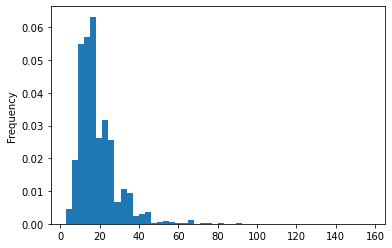

In [192]:
data['income_total'] = data['income_total']/10000 
print(data['income_total'].value_counts(bins=10,sort=False))
data['income_total'].plot(kind='hist',bins=50,density=True)

In [193]:
count, bin_dividers =np.histogram(data['income_total'], bins=7)

In [194]:
bin_names=['소득'+str(i) for i in range(7) ]
data['income_total']=pd.cut(x=data['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)

In [195]:
print(data['income_type'].unique())
print(data['edu_type'].unique())
print(data['family_type'].unique())
print(data['house_type'].unique())
print(data['occyp_type'].unique())
print(data['income_total'].unique())

['Commercial associate' 'Working' 'State servant' 'Pensioner' 'Student']
['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
['Married' 'Civil marriage' 'Separated' 'Single / not married' 'Widow']
['Municipal apartment' 'House / apartment' 'With parents'
 'Co-op apartment' 'Rented apartment' 'Office apartment']
['Unknown job' 'Laborers' 'Managers' 'Sales staff' 'High skill tech staff'
 'Core staff' 'Drivers' 'Medicine staff' 'Accountants' 'No job'
 'Realty agents' 'Security staff' 'Cleaning staff' 'Private service staff'
 'Cooking staff' 'Secretaries' 'HR staff' 'IT staff' 'Low-skill Laborers'
 'Waiters/barmen staff']
['소득0', '소득1', '소득2', '소득3', '소득4', '소득6', '소득5']
Categories (7, object): ['소득0' < '소득1' < '소득2' < '소득3' < '소득4' < '소득5' < '소득6']


In [196]:
#minus 변경하고
#구간화 함수
def make_bin(variable, n):
    data[variable]=-data[variable]
    count, bin_dividers =np.histogram(data[variable], bins=n)
    bin_names=[str(i) for i in range(n)]
    data[variable]=pd.cut(x=data[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    data[variable]=label_encoder.fit_transform(data[variable])

In [197]:
make_bin('DAYS_BIRTH', n=10)
make_bin('DAYS_EMPLOYED', n=6)
make_bin('begin_month', n=4)

In [198]:
data1=data.copy()

In [199]:
int_d=pd.get_dummies(data1["income_type"]).Student
data1["income_type"]=int_d

In [200]:
edu_d=pd.get_dummies(data1["edu_type"])["Academic degree"]
data1["edu_type"]=edu_d

In [201]:
data1.drop("family_type",axis=1,inplace=True)

In [202]:
hst_d=pd.get_dummies(data1["house_type"])["Rented apartment"]
data1["house_type"]=hst_d

In [203]:
data1.columns=['level_0', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'Student', 'Academic degree', 'Rented apartment', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'work_phone', 'phone', 'email', 'occyp_type', 'family_size',
       'begin_month', 'credit']
data1.head()

,level_0,gender,car,reality,child_num,income_total,Student,Academic degree,Rented apartment,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit
index,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,소득0,0,0,0,3,1,0,0,0,Unknown job,2.0,0,1.0
1,1,0,0,1,1,소득0,0,0,0,2,1,0,0,1,Laborers,3.0,0,1.0
2,2,1,1,1,0,소득1,0,0,0,6,1,0,1,0,Managers,2.0,1,2.0
3,3,0,0,1,0,소득0,0,0,0,4,1,0,1,0,Sales staff,2.0,2,0.0
4,4,0,1,1,0,소득0,0,0,0,4,1,0,0,0,Managers,2.0,1,2.0


In [204]:
occ_t=pd.get_dummies(data["occyp_type"])
occ_t.drop(occ_t.columns.drop(occ_t_list),axis=1,inplace=True)
occ_t.head()

,HR staff,IT staff,Low-skill Laborers,No job,Realty agents,Secretaries,Waiters/barmen staff
index,,,,,,,
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0


In [205]:
data1[occ_t_list]=occ_t
data1.drop("occyp_type",axis=1,inplace=True)
data1.head()

,level_0,gender,car,reality,child_num,income_total,Student,Academic degree,Rented apartment,DAYS_BIRTH,...,family_size,begin_month,credit,Realty agents,Secretaries,HR staff,IT staff,Low-skill Laborers,Waiters/barmen staff,No job
index,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,소득0,0,0,0,3,...,2.0,0,1.0,0,0,0,0,0,0,0
1,1,0,0,1,1,소득0,0,0,0,2,...,3.0,0,1.0,0,0,0,0,0,0,0
2,2,1,1,1,0,소득1,0,0,0,6,...,2.0,1,2.0,0,0,0,0,0,0,0
3,3,0,0,1,0,소득0,0,0,0,4,...,2.0,2,0.0,0,0,0,0,0,0,0
4,4,0,1,1,0,소득0,0,0,0,4,...,2.0,1,2.0,0,0,0,0,0,0,0


In [206]:
data=data1.copy()

In [207]:
from sklearn import preprocessing
label_encoder=preprocessing.LabelEncoder()
#data['income_type']=label_encoder.fit_transform(data['income_type'])
#data['edu_type']=label_encoder.fit_transform(data['edu_type'])
#data['family_type']=label_encoder.fit_transform(data['family_type'])
#data['house_type']=label_encoder.fit_transform(data['house_type'])
data['income_total']=label_encoder.fit_transform(data['income_total'])
#data['occyp_type']=label_encoder.fit_transform(data['occyp_type'])

In [208]:
data.tail()

,level_0,gender,car,reality,child_num,income_total,Student,Academic degree,Rented apartment,DAYS_BIRTH,...,family_size,begin_month,credit,Realty agents,Secretaries,HR staff,IT staff,Low-skill Laborers,Waiters/barmen staff,No job
index,,,,,,,,,,,,,,,,,,,,,
36452,9995,0,1,1,0,0,0,0,0,6,...,2.0,1,NaN,0,0,0,0,0,0,0
36453,9996,1,1,1,0,0,0,0,0,1,...,2.0,2,NaN,0,0,0,0,0,0,0
36454,9997,0,0,1,0,1,0,0,0,7,...,2.0,3,NaN,0,0,0,0,0,0,0
36455,9998,0,1,0,0,0,0,0,0,5,...,2.0,2,NaN,0,0,0,0,0,0,0
36456,9999,0,0,1,0,1,0,0,0,0,...,2.0,0,NaN,0,0,0,0,0,0,0


In [209]:
data.reset_index().set_index("level_0")

,index,gender,car,reality,child_num,income_total,Student,Academic degree,Rented apartment,DAYS_BIRTH,...,family_size,begin_month,credit,Realty agents,Secretaries,HR staff,IT staff,Low-skill Laborers,Waiters/barmen staff,No job
level_0,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,3,...,2.0,0,1.0,0,0,0,0,0,0,0
1,1,0,0,1,1,0,0,0,0,2,...,3.0,0,1.0,0,0,0,0,0,0,0
2,2,1,1,1,0,1,0,0,0,6,...,2.0,1,2.0,0,0,0,0,0,0,0
3,3,0,0,1,0,0,0,0,0,4,...,2.0,2,0.0,0,0,0,0,0,0,0
4,4,0,1,1,0,0,0,0,0,4,...,2.0,1,2.0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,36452,0,1,1,0,0,0,0,0,6,...,2.0,1,NaN,0,0,0,0,0,0,0
9996,36453,1,1,1,0,0,0,0,0,1,...,2.0,2,NaN,0,0,0,0,0,0,0
9997,36454,0,0,1,0,1,0,0,0,7,...,2.0,3,NaN,0,0,0,0,0,0,0


# 데이터 모델링

In [210]:
train=data[:len(data)-10000]
test=data[len(data)-10000:]

In [211]:
train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
test_x=test.drop('credit', axis=1)

In [212]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical

X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 10086)

print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)


clf=RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred=clf.predict_proba(X_val)

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

Train set: 
(19842, 23)
(19842, 1)
Validation set: 
(6615, 23)
(6615, 1)
log_loss: 1.3648338639136228


In [213]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        clf.fit(X_train, y_train)
        
        predictions=clf.predict_proba(X_val)
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=clf.predict_proba(test_x)
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(clf)

FOLD 0 : logloss:1.3654808451322857
FOLD 1 : logloss:1.3053160303947808
FOLD 2 : logloss:1.4153331008546632
FOLD 3 : logloss:1.376740128279629
FOLD 4 : logloss:1.4011414141008927
Mean:1.3728023037524504


In [214]:
my_submission

array([[0.124, 0.176, 0.7  ],
       [0.29 , 0.256, 0.454],
       [0.398, 0.064, 0.538],
       ...,
       [0.04 , 0.09 , 0.87 ],
       [0.028, 0.422, 0.55 ],
       [0.1  , 0.45 , 0.45 ]])

In [215]:
submission

,index,0,1,2
0,26457,0,0,0
1,26458,0,0,0
2,26459,0,0,0
3,26460,0,0,0
4,26461,0,0,0
...,...,...,...,...
9995,36452,0,0,0
9996,36453,0,0,0
9997,36454,0,0,0
9998,36455,0,0,0


In [216]:
submission.loc[:,1:]=my_submission

In [217]:
submission

,index,0,1,2
0,26457,0.124,0.176,0.700
1,26458,0.290,0.256,0.454
2,26459,0.398,0.064,0.538
3,26460,0.172,0.232,0.596
4,26461,0.196,0.352,0.452
...,...,...,...,...
9995,36452,0.026,0.200,0.774
9996,36453,0.156,0.114,0.730
9997,36454,0.040,0.090,0.870
9998,36455,0.028,0.422,0.550


In [218]:
submission.to_csv('C:\\Users\\eunai\\Documents\\컴퓨터공부\dacon\\baseline_submission_3.csv', index=False)